<a href="https://colab.research.google.com/github/Dacrath/CST383-Project-Sleep-Disorder-Analysis-and-Risk-Rediction/blob/main/CST383_ADJS_Consulting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADJS Consulting
## CST383 Project: Sleep Disorder Analysis and Risk Rediction

### Members
- Steven Jackson
- Andrew Kopf
- Jeremy Norvell
- Dominick Racela

## Project Idea

The sleep health dataset located on Kaggle at this [link](https://www.kaggle.com/datasets/adilshamim8/sleep-cycle-and-productivity) will be analyzed for risk factors which influence insomnia or sleep apnea. By analyzing the data for correlative features and cleansing of any potential outliers or spurious data, key risk factors can be identified which may help people adjust their habits to achieve better sleep. In addition, risk factors that are immutable (such as age) can be listed to assist people in developing healthier sleep habits as their bodies age.

In addition, since both apnea and insomnia are considered to be independent conditions, they will be used as separate target variables into a predictive modeling. This will allow exploration of multiple model types across separate predictive variables when generating an overall risk score for each condition.

Lastly, any interaction between variables which show a strong influence in either model can be analyzed as well as developing separate analysis between each condition to see how their predictors may be similar and how they may differ.


### Choice of Dataset

This dataset about sleep health and how it relates to lifestyle has information about an individual's sleep patterns, lifestyle habits, and health indicators. The goal of this dataset is to see how variations in sleep such as duration, quality, or consistency relates to daily performance metrics such as productivity and well-being. It contains basic columns like gender and age to characterize the individual. Columns such as sleep duration, quality of sleep, and stress levels are included to determine the individual's sleep patterns. Additional features include physical activity levels, caffeine consumption, and mood, which help researchers understand broader lifestyle influences. Overall, the dataset offers opportunities for exploring correlations between healthy sleep habits, stress management, and improved productivity outcomes.

### Data Dictionary

The dataset as provided on Kaggle provides a high-level data dictionary describing each of the variables. It has been copied below for reference. Each of these features will be discussed in later sections of this document to clarify their role in the project.

*   Person ID – Unique identifier for each individual
*   Gender – Male/Female
*   Age – Age of the individual
*   Occupation – Job category of the individual
*   Sleep Duration (hours) – Average sleep duration per day
*   Quality of Sleep (scale 1–10) – Self-reported sleep quality
*   Physical Activity Level (minutes/day) – Daily physical activity duration
*   Stress Level (scale 1–10) – Self-reported stress level
*   BMI Category – Body Mass Index classification (Normal/Overweight/Obese, etc.)
*   Blood Pressure (mmHg) – Systolic/Diastolic blood pressure
*   Heart Rate (bpm) – Resting heart rate
*   Daily Steps – Number of steps taken per day
*   Sleep Disorder – Sleep-related disorder (None, Insomnia, Sleep Apnea)

### Data Import

The below cell handles the import of the dataset from Kaggle and diplays the first few rows for validation of a correct import. This process follows a series of code instructions for the import of data from Kaggle into a Pandas dataframe found at the "code" link on the Kaggle project page.

In [1]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import graphviz
import numpy as np, matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import seaborn as sns
import matplotlib.pyplot as plt

# Set the path to the file you'd like to load
file_path = "Sleep_Health_and_Lifestyle_Dataset.csv"

# Load the latest version
df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS, "adilshamim8/sleep-cycle-and-productivity", file_path)
df.set_index('Person ID', inplace=True)

# Display the first 5 records
print("\n\nFirst 5 records:")
print(df.head())

# Show the file statistics, non-null counts, and file size
print("\n\nFile statistics:")
df.info()

# Show the distribution of records
print("\n\nData distribution of numeric variables:")
df.describe()

100%|██████████| 32.7k/32.7k [00:00<00:00, 21.6MB/s]



First 5 records:
          Gender  Age            Occupation  Sleep Duration  Quality of Sleep  \
Person ID                                                                       
1           Male   27     Software Engineer             6.1                 6   
2           Male   28                Doctor             6.2                 6   
3           Male   28                Doctor             6.2                 6   
4           Male   28  Sales Representative             5.9                 4   
5           Male   28  Sales Representative             5.9                 4   

           Physical Activity Level  Stress Level BMI Category Blood Pressure  \
Person ID                                                                      
1                               42             6   Overweight         126/83   
2                               60             8       Normal         125/80   
3                               60             8       Normal         125/80   
4            

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920
std,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679
min,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000
50%,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000
75%,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000
max,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000


### Observations and Preprocessing

While the original dataset has ten potential features to include in a model, four of these are of type "object" and will limit the number of machine learning algorithims that can be applied. In order to improve the data for analysis and model building, several features have been engineeered from the existing data. Processing details are listed below:

#### Features

1.   "Blood Pressure" displays a character string of XXX/YY, where XXX and YY represent systolic and diastolic blood pressure. These will be split into separate data elements to serve as potential features.
2.   "BMI Category" provides four categories: "Normal", "Normal Weight", "Overweight", and "Obese". These have been split into binary features using one-hot encoding. Further exploration may be needed to determine the difference between "Normal", and "Normal Weight"
3.   "Occupation" contains a series of values that will be binned into high, medium, and low quantiles which are represented by ascending integers (e.g. 0,1, and 2). These bins represent the correlation to each respective predictive variable.
4.   "Gender" is an object showing "male" and "female" values. This will be split into binary features using one-hot encoding to identify male observations.
#### Target Variables

1.  "Sleep Disorder" gives displays three values: NaN (no sleep disorder reported), "Insomnia", and "Sleep Apnea". These have been split into individual binary variables using one hot encoding. These variables will ultimately become the target variable for any emerging model.



In [2]:
# Split the blood pressure number into Systolic and Diastolic and convert to float.
df[['systolic_bp', 'diastolic_bp']] = df['Blood Pressure'].str.split('/', expand=True).astype(float)

# Convert BMI Categoy to one hot data and add to df.join.
df = df.join(pd.get_dummies(df['BMI Category'], dtype=int))

# Convert target variables to separate values via one hot and add back similar to the BMI category above
df = df.join(pd.get_dummies(df['Sleep Disorder'], dtype=int))

# Convert Gender to one hot data and add to df.join.
df = df.join(pd.get_dummies(df['Gender'], dtype=int))

# Drop converted variables to keep the dataset small and easier to browse
df.drop(['BMI Category', 'Blood Pressure', 'Sleep Disorder', 'Female', 'Gender'], axis=1, inplace=True)
print(df)


           Age            Occupation  Sleep Duration  Quality of Sleep  \
Person ID                                                                
1           27     Software Engineer             6.1                 6   
2           28                Doctor             6.2                 6   
3           28                Doctor             6.2                 6   
4           28  Sales Representative             5.9                 4   
5           28  Sales Representative             5.9                 4   
...        ...                   ...             ...               ...   
370         59                 Nurse             8.1                 9   
371         59                 Nurse             8.0                 9   
372         59                 Nurse             8.1                 9   
373         59                 Nurse             8.1                 9   
374         59                 Nurse             8.1                 9   

           Physical Activity Level  S

In [3]:
# Insomnia binning for occupation
# Mean probability by occupation
occupation_insomnia_rate = df.groupby('Occupation')['Insomnia'].mean().sort_values()

# Now merge those probabilities back into the dataset
df = df.merge(occupation_insomnia_rate.rename('occupation_insomnia_rate'), on='Occupation')

# Simple quantile binning
df['occupation_insomnia_bin'] = pd.qcut(df['occupation_insomnia_rate'], q=3, labels=['Low', 'Medium', 'High'])

# Turn these into numeric codes
df['occupation_insomnia_bin_code'] = df['occupation_insomnia_bin'].map({'Low': 0, 'Medium': 1, 'High': 2})

# Sleep Apnea binning for occupation
# Mean probability by occupation
occupation_apnea_rate = df.groupby('Occupation')['Sleep Apnea'].mean().sort_values()

# Now merge those probabilities back into the dataset
df = df.merge(occupation_apnea_rate.rename('occupation_apnea_rate'), on='Occupation')

# Simple quantile binning
df['occupation_apnea_bin'] = pd.qcut(df['occupation_apnea_rate'], q=3, labels=['Low', 'Medium', 'High'])

# Turn these into numeric codes
df['occupation_apnea_bin_code'] = df['occupation_apnea_bin'].map({'Low': 0, 'Medium': 1, 'High': 2})

# Drop temporary variables
df.drop(['occupation_insomnia_rate', 'occupation_insomnia_bin', 'occupation_apnea_rate', 'occupation_apnea_bin'], axis=1, inplace=True)

# Display the dataframe
df

,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,systolic_bp,diastolic_bp,Normal,Normal Weight,Obese,Overweight,Insomnia,Sleep Apnea,Male,occupation_insomnia_bin_code,occupation_apnea_bin_code
0,27,Software Engineer,6.1,6,42,6,77,4200,126.0,83.0,0,0,0,1,0,0,1,2,0
1,28,Doctor,6.2,6,60,8,75,10000,125.0,80.0,1,0,0,0,0,0,1,0,1
2,28,Doctor,6.2,6,60,8,75,10000,125.0,80.0,1,0,0,0,0,0,1,0,1
3,28,Sales Representative,5.9,4,30,8,85,3000,140.0,90.0,0,0,1,0,0,1,1,0,2
4,28,Sales Representative,5.9,4,30,8,85,3000,140.0,90.0,0,0,1,0,0,1,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,59,Nurse,8.1,9,75,3,68,7000,140.0,95.0,0,0,0,1,0,1,0,0,2
370,59,Nurse,8.0,9,75,3,68,7000,140.0,95.0,0,0,0,1,0,1,0,0,2
371,59,Nurse,8.1,9,75,3,68,7000,140.0,95.0,0,0,0,1,0,1,0,0,2
372,59,Nurse,8.1,9,75,3,68,7000,140.0,95.0,0,0,0,1,0,1,0,0,2


## Exploration and Visualization

To better understand relationships within our data, our next step is to generate basic visualizations using both default and engineered variables.  
These will help identify patterns and correlations that could improve model accuracy.

Histograms can show distributions for key numeric variables:

*   Age
*   Sleep Duration
*   Stress Level
*   Quality of Sleep
*   Systolic and Diastolic Blood Pressure

Scatterplots can show potential correlations between variables:

*   Stress Level vs. Sleep Duration
*   Sleep Duration vs. Quality of Sleep
*   Age vs. Systolic Blood Pressure
*   Heart Rate vs. Stress Level

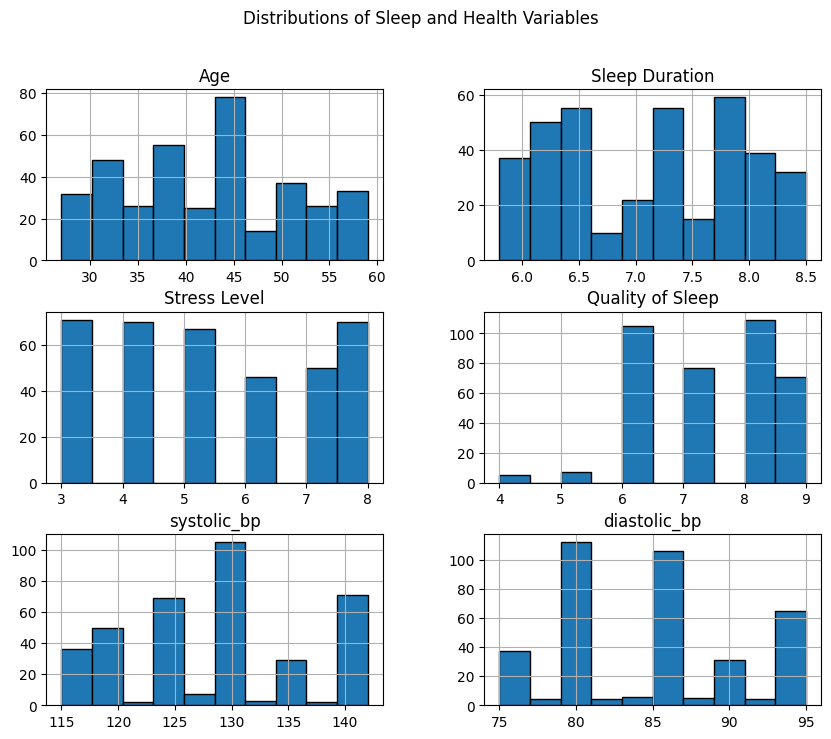

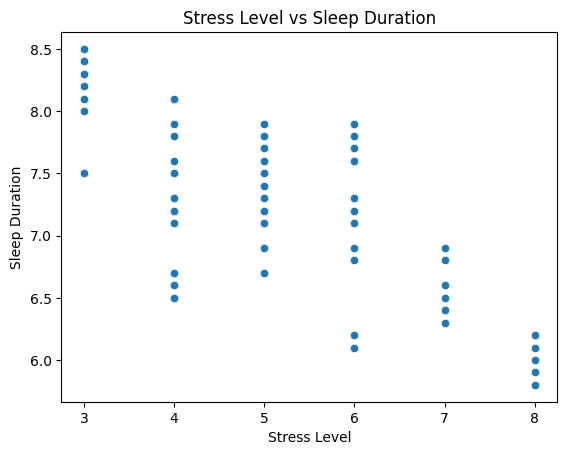

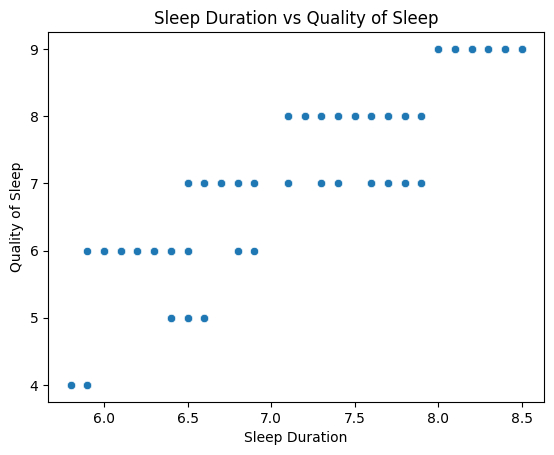

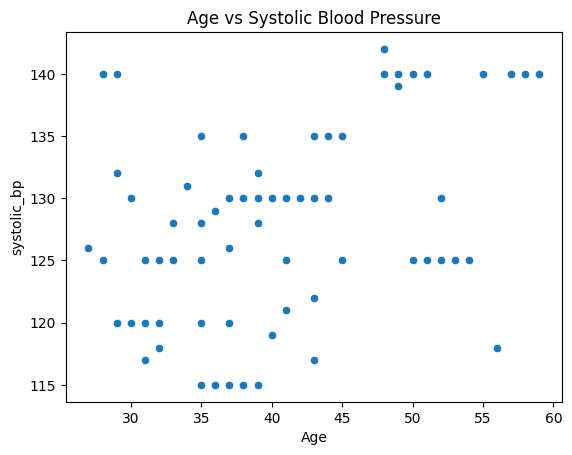

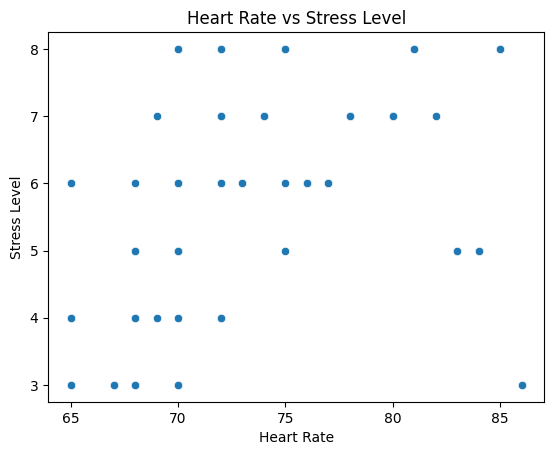

In [4]:
# Histograms
cols = ['Age', 'Sleep Duration', 'Stress Level', 'Quality of Sleep', 'systolic_bp', 'diastolic_bp']
df[cols].hist(figsize=(10,8), bins=10, edgecolor='black')
plt.suptitle("Distributions of Sleep and Health Variables")
plt.show()

# Scatterplots
sns.scatterplot(data=df, x="Stress Level", y="Sleep Duration")
plt.title("Stress Level vs Sleep Duration")
plt.show()

sns.scatterplot(data=df, x="Sleep Duration", y="Quality of Sleep")
plt.title("Sleep Duration vs Quality of Sleep")
plt.show()

sns.scatterplot(data=df, x="Age", y="systolic_bp")
plt.title("Age vs Systolic Blood Pressure")
plt.show()

sns.scatterplot(data=df, x="Heart Rate", y="Stress Level")
plt.title("Heart Rate vs Stress Level")
plt.show()

Majority of the participants in the 25–60 years age group with an average sleep duration between 6–8 hours and sleep quality scores of 6–8 which indicates generally adequate rest. Their stress levels are moderate to high with blood pressure readings that fall within normal limits. The data represents a relatively healthy adult group with moderate variation in sleep and lifestyle factors.

## Initial Predictions

Logistic regression allows us to predict the probability of a person may develop sleep apnea as they age. A person at age 40 has 0.126 probability of developing sleep apnea versus a person at age 50 that has a probability of 0.3519.


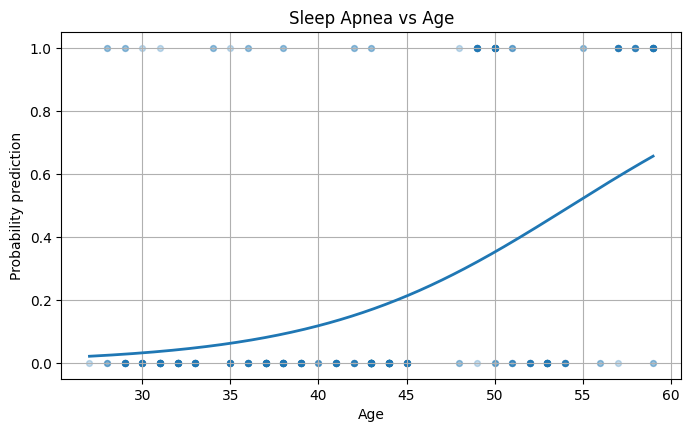

In [5]:
randomState = 42

df["SleepApnea"] = df["Sleep Apnea"]
df = df.dropna(subset=["Age","SleepApnea"])
X = df[["Age"]].values; y = df["SleepApnea"].values

# logistic training
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=randomState)
scaler = StandardScaler().fit(X_tr); X_tr_s = scaler.transform(X_tr); X_te_s = scaler.transform(X_te)
model = LogisticRegression(max_iter=2000, random_state=randomState).fit(X_tr_s, y_tr)
y_prob = model.predict_proba(X_te_s)[:,1]; y_pred = model.predict(X_te_s)

age_min, age_max = int(df["Age"].min()), int(df["Age"].max())
ages = np.linspace(age_min, age_max, 300).reshape(-1,1)
probs = model.predict_proba(scaler.transform(ages))[:,1]

# Display Graph
plt.figure(figsize=(8,4.5))
plt.plot(ages.ravel(), probs, lw=2)
plt.scatter(df["Age"], df["SleepApnea"], s=18, alpha=0.25, label="Observed (0/1)")
plt.xlabel("Age");
plt.ylabel("Probability prediction");
plt.title("Sleep Apnea vs Age");
plt.grid(True, linestyle="-")
plt.show()

The blue curve in the above graph demonstrates that the predicted probability of sleep apnea increase with age.  At younger ages (25-35) the model predicts a low chance of sleep apnea.  When a person reaches their mid-50’s and up, the probability of sleep apnea dramatically increases to 60 – 70% chance of developing sleep apnea.

In [6]:
# Scaling data for use in KNN. This uses Z-Scaling
# Takes a pandas daraframe, array of predictors and a target variable
# Returns scaled X_train, X_test data along with y_train, and y_test arrays.
# Example code
# predictors = ['Age','Stress Level','systolic_bp','Quality of Sleep']
# X_train, X_test, y_train, y_test = knn_z_scaling(df, predictors, 'SleepApnea')

def knn_z_scaling(df, predictors, target):
  X = df[predictors].values
  y = df[target].values

  #Split data into Training and Test data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

  #Scale the X data for the KNN models
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  return X_train, X_test, y_train, y_test

In [7]:
# Scaling data for use in KNN. This uses MinMax Scalling
# Takes a pandas daraframe, array of predictors and a target variable
# Returns scaled X_train, X_test data along with y_train, and y_test arrays.
# Example code
# predictors = ['Age','Stress Level','systolic_bp','Quality of Sleep']
# X_train, X_test, y_train, y_test = knn_minmax_scaling(df, predictors, 'SleepApnea')

def knn_minmax_scaling(df, predictors, target):
  X = df[predictors].values
  y = df[target].values

  #Split data into Training and Test data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

  #Scale the X data for the KNN models
  scaler = MinMaxScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  return X_train, X_test, y_train, y_test


## Predicting Insomnia

While the above logistic regression model gives us a quick overview of how a model can be used to see if a prediction is possible, it does not take advantage of machine learning for optimization.

The section below will explore how Python and related libraries can be used to create a more optimal prediciton model for Insomnia and what we can learn from it.



### Grid Search Approach

The code below uses machine learning in what is effectively a grid search methodology. This iterates through multiple hyperparameters and input predictors in order to find an optimum model for the prediction of the insomnia variable. A decision tree is used for this portion of the model in order to build experience and show the visual explainability of this type of model.

In order to avoid overfitting, hyperparameters for the minimum samples per leaf (min_samples_leaf) and the maximum tree depth (max_depth) were both chosen at 5 and 3, respectively. These were selected after some experimentation with building trees and seem to give a balance between optimization and overfitting. A quick internet search shows that these are commonly accepted values to reduce overfitting.

In addition, the code below allows hyperparameters to be applied in a deliberately chosen order. This is intentional should the model developer want to prioritize explainability over performance. For example, using 'best' settings for split will often be more easily interpreted than 'random'. The latter of these may produce counterintuitve results.

In [8]:
# Create a copy of our dataframe for use in this section
df_dt = df.copy()

# Define our predictors and target variables. All predictors are included other than
# those that have historically had covariance with other variables (systolic and diastolic pb)
# or those that effectively have the same definition as the target variable (e.g. length of
# sleep and insomnia)
predictors = ['Age','occupation_insomnia_bin_code','Quality of Sleep',
              'Physical Activity Level','Stress Level','Heart Rate','Daily Steps',
              'systolic_bp','Normal','Normal Weight','Obese','Overweight','Male']
target = 'Insomnia'

# Split into predictor and target dataframes
X = df_dt[predictors].values
y = df_dt[target].values

# Create test and training datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=187)

# Helper function to get accuracy
# This performs a quick comparison between actual and predicted
# values and returns an overall accuracy rate.
def get_accuracy(prediction, test):
  return((prediction == test).mean())

# This is a function designed to apply the model training and test
# with multiple hyperparameters in order to locate optimal settings
# It has been adapated from the 'get_train_test_rmse' function developed
# during a homework assignment
def get_train_test_accuracy(clf, X_train, X_test, y_train, y_test):
    # Fit the model with our training data
    clf.fit(X_train, y_train)

    # Calculate RMSE for training data
    train_prediction = clf.predict(X_train)
    train_accuracy = get_accuracy(train_prediction, y_train)

    # Now calculate RMSE for the test data
    test_prediction = clf.predict(X_test)
    test_accuracy = get_accuracy(test_prediction, y_test)

    return train_accuracy, test_accuracy

# This function probes the model with supplied hyperparameters and
# appends data to the lists for later grid search optimization
def model_probe(X_train, X_test, y_train, y_test, criteria, split, feature):
    clf = DecisionTreeClassifier(criterion=criteria,
                                 splitter=split,
                                 max_features=feature,
                                 min_samples_leaf=5,
                                 max_depth=3,
                                 random_state=187)
    acc_tr, acc_te = get_train_test_accuracy(clf, X_train, X_test, y_train, y_test)
    criterion.append(criteria)
    splitter.append(split)
    feature_max.append(feature)
    train_accuracy.append(acc_tr)
    test_accuracy.append(acc_te)
    models.append(clf)

# Invoke a loop based on the number of features for the model
# This starts at two predictors and builds to the entire set
n = len(predictors)                                  # Determine the number of predictors availale in the dataset
criterion = []                                       # List used to store the criterion setting for the model
splitter = []                                        # List used to store the splitter setting for the model
feature_max = []                                     # List used to store the maximum number of features for the model
test_accuracy = []                                   # List used to store the accuracy on the test data
train_accuracy = []                                  # List used to store the accuracy on the training data
models = []                                          # List used to store the model
features = np.arange(2, n+1)                         # Iterate through the features from 2 to all

# This will loop through the number of features, probing gini/entropy/log_loss,
# and best/random hyperparameters on each loop. These are manually assigned
# in order to give the analyst some choice over which set is selected when equal
# performance is observed.
for feature in features:
    print(feature, ' ', end='')
    model_probe(X_train, X_test, y_train, y_test, 'gini', 'best', feature)
    model_probe(X_train, X_test, y_train, y_test, 'entropy', 'best', feature)
    model_probe(X_train, X_test, y_train, y_test, 'log_loss', 'best', feature)
    model_probe(X_train, X_test, y_train, y_test, 'gini', 'random', feature)
    model_probe(X_train, X_test, y_train, y_test, 'entropy', 'random', feature)
    model_probe(X_train, X_test, y_train, y_test, 'log_loss', 'random', feature)
print('done')


2  3  4  5  6  7  8  9  10  11  12  13  done


### Model Selection

Model selection uses the best performance, and loads the first model with that performance into an object: 'best_model'. As noted above, loading the first model with this optimal performance allows the model developer to apply some discretion to which hyperparameters might be prioritized to the end-user needs.

In [9]:
# This searches the above results to find which hyperparameters gave
# the best accuracy
def get_best(criterion, splitter, features, accuracy, models):
    # Convert Python lists to Numpy arrays
    criterion = np.array(criterion)
    splitter = np.array(splitter)
    features = np.array(features)
    accuracy = np.array(accuracy)
    models = np.array(models)

    # Determine our best accuracy
    max_accuracy = np.max(accuracy)

    # Now get the hyperparameters associated with the first entry for it
    # We are deliberately choosing the first entry as hyperparameters are
    # largely increasing complexity as the list lengthens
    criteria = criterion[accuracy == max_accuracy][0]
    split = splitter[accuracy == max_accuracy][0]
    feature = features[accuracy == max_accuracy][0]
    model = models[accuracy == max_accuracy][0]

    # Return the values
    return criteria, split, feature, max_accuracy, model

best_criteria, best_split, best_features, best_accuracy, best_model = get_best(criterion,
                                                                               splitter,
                                                                               feature_max,
                                                                               test_accuracy,
                                                                               models)
print('The optimal decision tree uses ' + best_criteria +
      ' criterion, ' + best_split + ' splitter, ' +
      'and max_features={}. \nThis gives the best test accuracy rate: {:0.3f}'.format(best_features, best_accuracy))
print('This model has been loaded to the object "best_model" for evaluation.')

The optimal decision tree uses gini criterion, best splitter, and max_features=8. 
This gives the best test accuracy rate: 0.982
This model has been loaded to the object "best_model" for evaluation.


### Visualizing the Decision Tree

The graph below shows the final decision tree. In this we see that body weight and physical activity level form the first splits, with age, gender, and activity level being utilized for downstream splits.

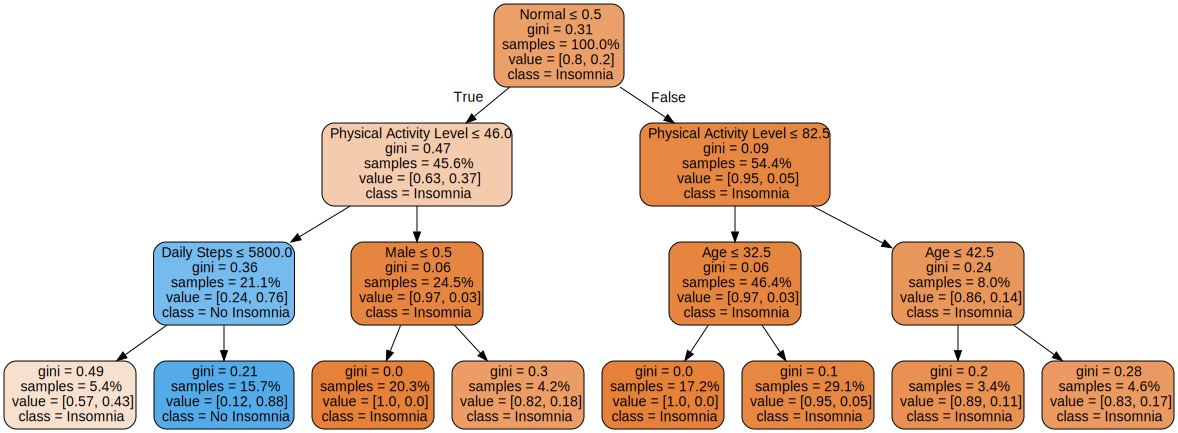

In [10]:
# Visualize the tree using the default code from our lab
target_names = ['Insomnia','No Insomnia']
dot_data = export_graphviz(best_model, precision=2,
                 	feature_names=predictors,
                 	proportion=True,
                 	class_names=target_names,
                 	filled=True, rounded=True,
                 	special_characters=True)

# plot it
graph = graphviz.Source(dot_data)
graph

### Confusion Matrix

The confustion matrix below shows the model performance on the test data. Accuracy is quite high (98.2%) with all insomnia classes being properly identified. 'No insomnia' is misclassified in two instances. While this current configuration shows that insomnia is always accurately predicted, it does allow for over-prediction. If the ultimate use of this model determines that false positive classifications are an issue, model retraining may be necessary.

Accuracy: 0.982


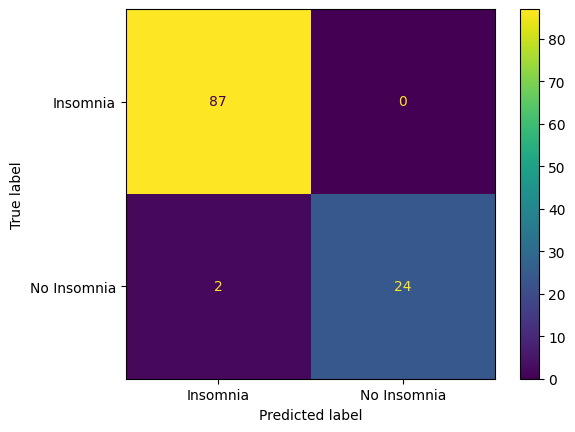

In [11]:
# Generate a prediction
y_predict = best_model.predict(X_test)

# Display the accuracy
print('Accuracy: {:0.3f}'.format(get_accuracy(y_predict, y_test)))

# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix display is using a layout from the below URL
# https://www.w3schools.com/python/python_ml_confusion_matrix.asp
cm = confusion_matrix(y_test, y_predict)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)

cm_display.plot()
plt.show()

### Model Interpretation

At a glance, the model tells us that the biggest predictor of insomnia is a non-normal weight class. The test data is split fairly evenly (45%/55%) by this class, but those within the 'normal' class have only a 0.63 probability, while those outside of it (which includes obese and overweight observations) have a much higher base probability of 0.95.

While other splits are made throughout the tree, it effectively classifies all non-normal weight classes as insomnia with a reasonable degree of accuracy. Within the normal weight branches, further classification largely relies on activitiy level. Surprisingly, those who reported under 47 minutes per day can be fairly reliably classifed as not having insomnia while those with more activity report insomnia consistently. The latter is rather counterintuitive, as traditionally one associates improved activity levels with better sleep.

## Predicting Apnea

This uses the k-Nearest Neighbors (kNN) machine learning model to predict if a person has sleep apnea. It defines the sleep apnea column as the target variable and selects health and lifestyle features such as age, sleep duration, and gender as predictors. It then removes missing data and gives the dataset a training and testing split of 70/30 respectively. The model is trained and tested 12 times with different k-values and weighting methods (uniform and distance). The results shows how each model performed and helps identify which k and weighting method gives the highest prediction accuracy.


In [12]:
# repeatability
np.random.seed(42)
RANDOM_STATE = 42

# Choose sleep apnea as the target column
target_col = "SleepApnea"

candidate_predictors = [
    "Age","Sleep Duration","Quality of Sleep","Physical Activity Level",
    "Stress Level","Heart Rate","Daily Steps","systolic_bp","diastolic_bp",
    "Normal","Normal Weight","Overweight","Obese","Male" ]
predictors = candidate_predictors

work = df.dropna(subset=predictors + [target_col]).copy()
X = work[predictors].values
y = work[target_col].values.astype(int)

# Split the data into Train/Test and scale features
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE
)

scaler = StandardScaler().fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)

# Run ~12 kNN passes (k in {1,3,5,7,9,11} × weights in uniform and distance)
# Train each model and collect the Test accuracy
ks = [1,3,5,7,9,11]
weights = ["uniform","distance"]

rows = []
for k in ks:
    for w in weights:
        clf = KNeighborsClassifier(n_neighbors=k, weights=w, algorithm="brute")
        clf.fit(X_train, y_train)
        acc = accuracy_score(y_test, clf.predict(X_test))
        rows.append({"k": k, "weights": w, "test_accuracy": acc})

results_df = pd.DataFrame(rows).sort_values("test_accuracy", ascending=False).reset_index(drop=True)
print(results_df.to_string(index=False, formatters={"test_accuracy": "{:.3f}".format}))


 k  weights test_accuracy
 3  uniform         0.929
 7  uniform         0.929
 5  uniform         0.920
 3 distance         0.920
 9 distance         0.920
 9  uniform         0.920
 7 distance         0.920
 5 distance         0.912
11  uniform         0.903
11 distance         0.903
 1  uniform         0.885
 1 distance         0.885


###Retrain the best model

The best model is used from the results above and rebuilds it. It is trained on the scaled training data, uses it to predict sleep apnea for the test set, then prints the a result displaying the k, weighting, and test accuracy.

In [13]:
best = results_df.iloc[0]
best_model = KNeighborsClassifier(n_neighbors=int(best.k), weights=best.weights, algorithm="brute")
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(f"\nBest: k={int(best.k)}, weights='{best.weights}', test_accuracy={best.test_accuracy:.3f}")


Best: k=3, weights='uniform', test_accuracy=0.929


###Confusion Matrix

This confusion matrix displays that the model correctly predicted that 84 samples had no sleep apnea and that 21 samples had sleep apnea. A small sample of people were incorrectly identified as indicated by the top right and bottom left squares on the confusion matrix. Overall, the confusion matrix is able to display the model's high accuracy as evidenced by its high amount of true positives and true negatives.

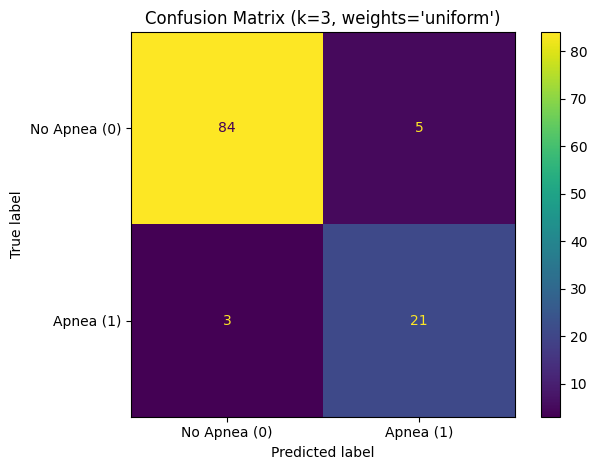

In [14]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["No Apnea (0)","Apnea (1)"]).plot(values_format="d")
plt.title(f"Confusion Matrix (k={int(best.k)}, weights='{best.weights}')")
plt.tight_layout()
plt.show()